Business objective: 
Obtaining project health information is challenging. Project managers are busy and find it difficult to manually enter data into multiple corporate systems (client side and system integrator side). One small step to ease this burden is to use mobile apps that ASSIST project managers by autofilling  some of the dynamic fields, using predictions from previously entered fields. A subset of this problem is entering multi-select options, which are often incorrectly entered on mobile apps.


Technical approach: 
This is dealt with as a multi-label problem. scikit-learn's excellent one vs/ rest and classifier chains wrappers around different classifiers have been implemented. Word embeddings have been trained for this specific corpus using TF-Hub. Kaggle's toxic comments multi-label dataset is a proxy for the real data.  

External references:
1.   scikit-learn's mutli-label algorithms [documentation](https://scikit-learn.org/stable/modules/multiclass.html).
2.   Jeremy Howard's top ranked toxic comment classification [kernel](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline), that uses a different solution approach.
3.   [TF-Hub ](https://www.tensorflow.org/hub/tutorials/text_classification_with_tf_hub) embeddings.






In [0]:
#Download kaggle.json from Kaggle -- MyAccount -- Create New API Token - auto downloads as "kaggle.json
#Import json into notebook - run in a cell 
from google.colab import files
files.upload()

#Browse to downloaded kaggle.json and upload

In [4]:
#Setup Kaggle DIR; copy json file ; chmod (rights)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [0]:
#Verify json content
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

In [6]:
#download Kaggle dataset
#!kaggle config path -p /content
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 94.4MB/s]
 38% 9.00M/23.4M [00:00<00:00, 24.6MB/s]
100% 23.4M/23.4M [00:00<00:00, 43.5MB/s]
 34% 9.00M/26.3M [00:00<00:00, 33.9MB/s]
100% 26.3M/26.3M [00:00<00:00, 66.5MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 165MB/s]


In [0]:
import os
import zipfile
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.utils import resample#downsampling

from sklearn.model_selection import train_test_split

from sklearn.multioutput import ClassifierChain #key library to chain classifiers
from sklearn.multiclass import OneVsRestClassifier #wrapper that enables focusing on one label at a time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import jaccard_score #ImportError: cannot import name 'jaccard_score', for scikit learn < 0.21
#from sklearn.metrics import jaccard_similarity_score #for scikit learn < 0.21
from sklearn.metrics import accuracy_score

pd.set_option('display.max_colwidth', -1)
from IPython.display import display


In [0]:
#plot of Number of comments by label
def plotNumberCommentsLabel(df):
    categories = list(df.iloc[:,2:].columns.values)
    sns.set(font_scale = 2)
    plt.figure(figsize=(15,8))
    ax= sns.barplot(categories, df.iloc[:,2:].sum().values)
    plt.title("Number of comments by label", fontsize=24)
    plt.ylabel('Number of comments', fontsize=18)
    plt.xlabel('Comment Label ', fontsize=18)
    #adding the text labels
    rects = ax.patches
    labels = df.iloc[:,2:].sum().values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
    plt.show()

In [0]:
#plot of Frequency of number of labels per comment
def plotFreqNumberLabelsComment(df):
    rowSums = df.iloc[:,2:].sum(axis=1)
    multiLabel_counts = rowSums.value_counts()
    #multiLabel_counts = multiLabel_counts.iloc[1:]#excludes single label
    sns.set(font_scale = 2)
    plt.figure(figsize=(15,8))
    ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
    plt.title("Frequency of number of labels per comment")
    plt.ylabel('Number of comments', fontsize=18)
    plt.xlabel('Number of labels', fontsize=18)
    #adding the text labels
    rects = ax.patches
    labels = multiLabel_counts.values
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    plt.show()

In [0]:
#sentence embedding
def text2embed(text):
    with tf.Graph().as_default():
      #hub_module="/home/bala/Documents/TFHUB1/2cdbcae1a547f4fb93475d4b7d4140f8590995b7"#locally stored nnlm-en-dim128-with-normalization
      hub_module="https://tfhub.dev/google/nnlm-en-dim128-with-normalization/1"
      embed = hub.Module(hub_module, trainable=True)#note module is trainable
      embeddings = embed(text)

      with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())

        (sess.run(embeddings))
        embedText=pd.DataFrame(embeddings.eval())
    return embedText

In [11]:
#check downloaded dataset availability 
os.chdir('/content')
!ls -d $PWD/*

/content/kaggle.json		    /content/test.csv.zip
/content/sample_data		    /content/test_labels.csv.zip
/content/sample_submission.csv.zip  /content/train.csv.zip


In [13]:
#file operations on specific file of interest
zip_ref = zipfile.ZipFile('train.csv.zip', 'r')
zip_ref.extractall()
zip_ref.close()

data_1 = pd.read_csv('train.csv')
print(data_1.shape)
data_1.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [0]:
#adding a label (none) for unlabelled comments
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
data_1['none'] = 1-data_1[label_cols].max(axis=1)

#for rows with no comment text
COMMENT = 'comment_text'
data_1[COMMENT].fillna("unknown", inplace=True)

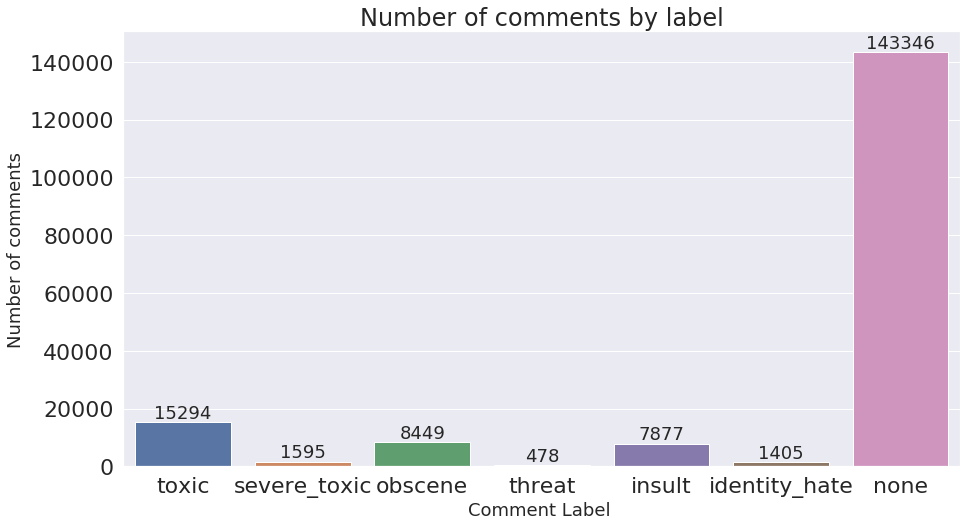

In [15]:
plotNumberCommentsLabel(data_1)

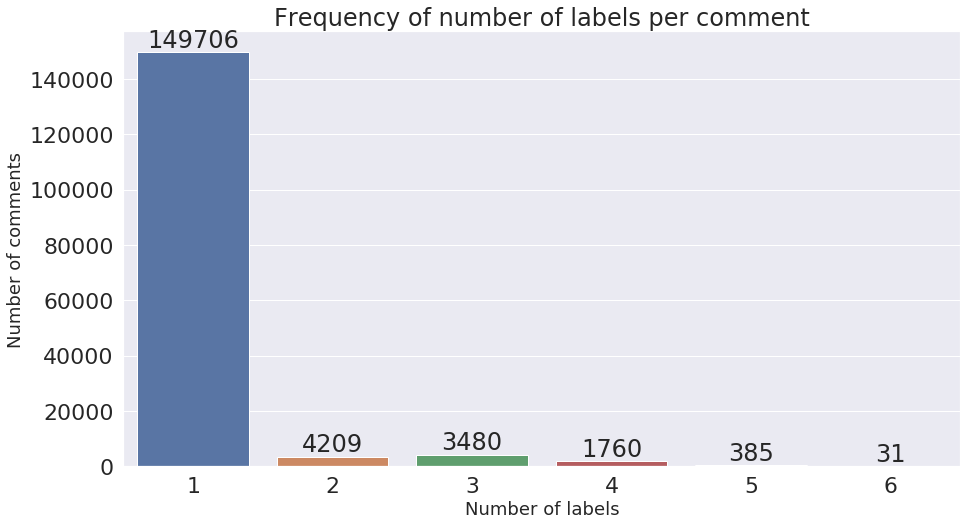

In [16]:
plotFreqNumberLabelsComment(data_1)

In [0]:
#balancing the dataset by downsampling 'none' 
dfClass1 = data_1[data_1.none == 1]
dfClass02 = data_1[data_1.none != 1]
dfClass1DownSampled = resample(dfClass1, replace = False, n_samples = 10000, random_state = 6)
dfBalanced = pd.concat((dfClass1DownSampled, dfClass02), axis=0)
dfBalanced = dfBalanced.reset_index(drop=True)


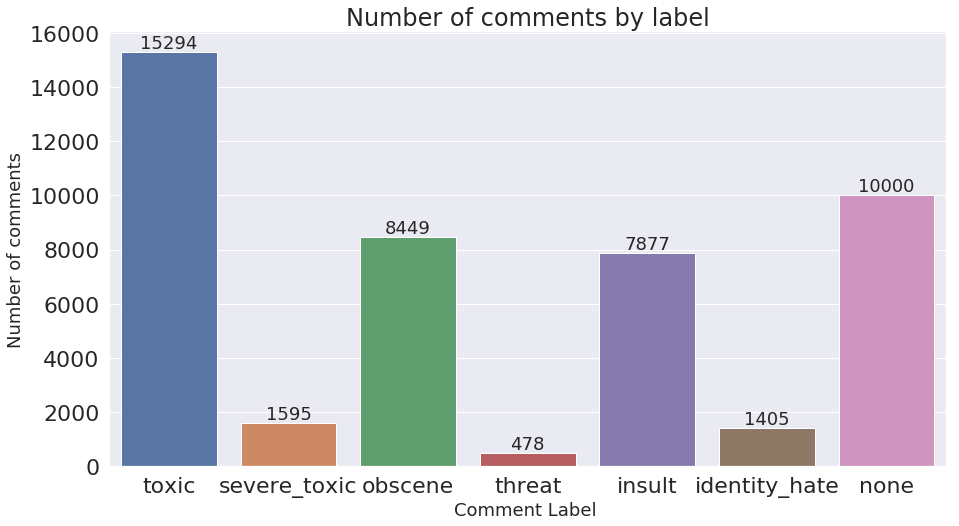

In [18]:
plotNumberCommentsLabel(dfBalanced)

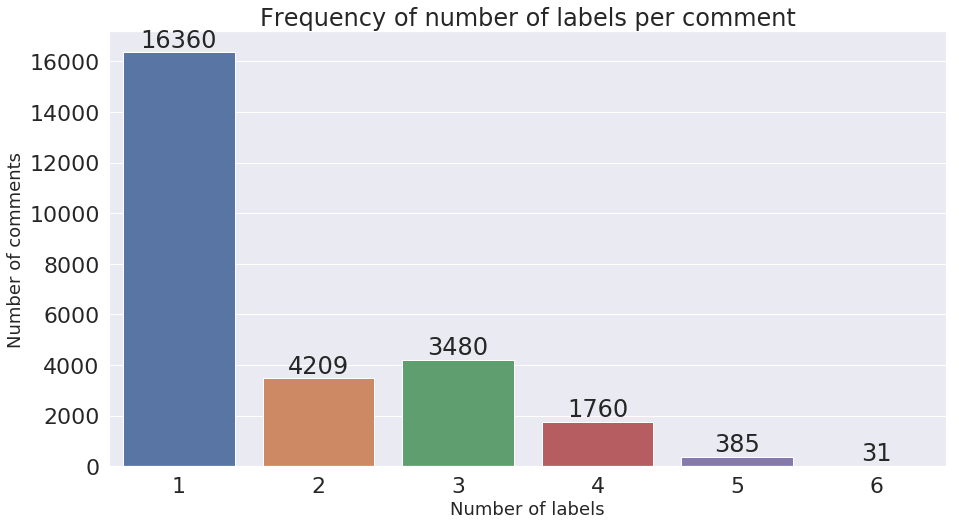

In [19]:
plotFreqNumberLabelsComment(dfBalanced)

In [20]:
#embedded_text_feature_column
embedText = text2embed(dfBalanced[COMMENT].tolist())#must convert to list
embedText.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.622593,0.053443,-0.011963,-0.010170,-0.022307,0.225227,0.025916,-0.154674,-0.192514,0.147784,0.234314,-0.036591,-0.079565,0.079443,-0.109029,0.049791,-0.289655,-0.083741,0.161754,0.629947,0.034912,-0.023733,-0.067631,-0.222207,0.098078,-0.078821,0.113381,-0.032717,0.142799,-0.105678,0.121248,0.054432,-0.126337,0.178008,0.136068,0.013161,0.055781,0.019827,-0.102716,-0.099816,...,0.156929,0.313961,0.003536,0.117564,0.194317,0.017221,0.114995,0.027695,-0.087959,-0.312731,-0.036789,-0.020589,-0.017995,-0.100485,0.159835,0.250822,0.025856,0.038864,0.142944,-0.039089,0.092530,0.209149,-0.074863,-0.075621,-0.156065,-0.107483,-0.097339,-0.012799,-0.060604,-0.106663,-0.036989,0.075729,-0.154046,-0.135370,0.089254,0.027607,-0.133899,-0.147590,-0.157684,-0.124685
1,0.757093,-0.010217,0.086636,0.144825,0.150240,-0.197285,0.050113,-0.175737,-0.048768,0.023938,0.053518,-0.269706,-0.081651,-0.156308,-0.054254,-0.068897,-0.022127,0.189523,-0.247081,0.137286,0.118075,0.106804,-0.039890,-0.154940,0.128563,0.022810,-0.038058,-0.006854,-0.070429,0.028706,0.020917,0.006826,0.051955,-0.000779,-0.017713,0.018550,-0.130515,-0.150052,-0.024978,0.118697,...,0.809657,0.290690,-0.185208,0.012130,-0.002620,-0.380093,0.019281,0.075121,-0.052113,-0.037367,-0.256962,-0.114255,0.014677,0.153820,0.166257,0.137735,0.132075,-0.039294,-0.044159,-0.025015,-0.098319,0.137256,-0.401403,-0.069123,-0.024796,-0.336935,0.004061,-0.160596,-0.067011,0.062300,0.020586,0.015818,-0.038791,-0.130539,0.169524,0.039812,-0.038608,-0.050763,-0.156834,0.007016
2,1.546915,0.502400,0.084020,-0.224684,-0.230054,0.239585,-0.027853,0.051666,-0.087721,0.329863,0.210872,-0.228031,-0.103799,0.018178,-0.303831,0.100432,-0.277442,-0.161751,-0.134071,1.498861,0.140519,0.086591,-0.015022,0.078631,-0.069289,-0.157844,0.158693,-0.038393,-0.107600,-0.041082,0.086137,-0.182951,0.166354,-0.001186,0.229195,-0.145114,-0.055571,-0.033559,-0.193256,0.117859,...,0.598581,0.586684,0.039585,-0.028268,0.236324,-0.181676,0.146452,0.064916,-0.278235,-0.006886,-0.193532,-0.076915,-0.022670,0.084236,0.312115,-0.064263,-0.020064,-0.104477,0.038013,0.050777,-0.123774,0.124891,-0.322657,-0.151569,-0.294773,-0.300827,0.099484,-0.272789,0.180212,-0.091749,-0.090725,-0.100405,0.320032,-0.114475,0.118758,0.088322,-0.149634,-0.264591,-0.013202,0.096443
3,0.155232,-0.052725,0.220986,0.100618,0.003990,-0.014820,-0.061161,-0.123028,-0.015022,0.041808,-0.115192,-0.190961,0.019282,0.005121,-0.019500,0.113378,0.009219,-0.042744,-0.048866,-0.007922,-0.030982,0.009537,-0.087530,-0.036532,0.148640,0.106829,-0.015644,0.016987,-0.120201,-0.078483,-0.107672,-0.138010,-0.074778,-0.086075,0.008468,-0.005850,-0.079267,-0.015331,0.078149,0.206003,...,0.174335,-0.074098,-0.210444,-0.010178,0.064594,-0.231778,0.090388,0.001131,-0.028331,0.107967,-0.137971,-0.024887,-0.029241,-0.109711,0.204758,-0.133498,0.076753,0.003068,-0.071122,-0.034044,-0.043668,0.006977,-0.225309,0.034008,-0.058414,-0.098267,-0.004401,-0.161812,-0.093345,-0.100216,-0.179070,0.023854,0.106424,-0.028248,-0.021636,0.153109,0.077641,0.031959,-0.081252,0.048424
4,1.022478,0.207326,-0.029680,-0.115696,-0.096329,-0.010141,-0.044273,0.103770,-0.091548,0.244115,0.053503,-0.066366,-0.058629,-0.120674,-0.104071,0.092956,-0.142055,-0.002618,-0.133264,0.964365,0.114622,0.088885,-0.112303,-0.155232,0.088905,0.000361,0.021919,0.092960,-0.015321,-0.014596,0.143563,0.165722,0.169213,-0.105172,0.030436,-0.011713,-0.249967,-0.070463,-0.045784,0.194297,...,0.582480,0.223761,-0.150416,0.100959,0.102854,-0.252522,0.047674,0.160584,-0.312017,0.085178,-0.303910,-0.106751,0.002361,0.137849,0.367941,-0.062631,0.054182,-0.121435,0.068639,-0.053879,-0.143134,0.124602,-0.315564,-0.086528,-0.147304,-0.216342,-0.087201,-0.256065,0

In [22]:
print(dfBalanced.shape)
print(dfBalanced.head())
print(embedText.head())
print(embedText.shape)
print(embedText.head())

(26225, 9)
                 id  ... none
0  0d200ed3f5ca6a14  ...  1  
1  6cce9795d21f210c  ...  1  
2  324b272d5bdd47d8  ...  1  
3  8998d61a55e36afb  ...  1  
4  3c82a2730d8fa486  ...  1  

[5 rows x 9 columns]
          0         1         2  ...       125       126       127
0  0.622593  0.053443 -0.011963  ... -0.147590 -0.157684 -0.124685
1  0.757093 -0.010217  0.086636  ... -0.050763 -0.156834  0.007016
2  1.546915  0.502400  0.084020  ... -0.264591 -0.013202  0.096443
3  0.155232 -0.052725  0.220986  ...  0.031959 -0.081252  0.048424
4  1.022478  0.207326 -0.029680  ... -0.064102  0.049118  0.176431

[5 rows x 128 columns]
(26225, 128)
          0         1         2  ...       125       126       127
0  0.622593  0.053443 -0.011963  ... -0.147590 -0.157684 -0.124685
1  0.757093 -0.010217  0.086636  ... -0.050763 -0.156834  0.007016
2  1.546915  0.502400  0.084020  ... -0.264591 -0.013202  0.096443
3  0.155232 -0.052725  0.220986  ...  0.031959 -0.081252  0.048424
4  1.022478  

In [23]:
#merge the sentence embeddings with the id, comment and classification labels
data_2 = pd.concat([embedText,dfBalanced], axis=1, join='inner')
data_2.columns = data_2.columns[0:128].tolist() + dfBalanced.columns.tolist()
print(data_2.shape)
print(data_2.columns)

(26225, 137)
Index([              0,               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,
       ...
                   127,            'id',  'comment_text',         'toxic',
        'severe_toxic',       'obscene',        'threat',        'insult',
       'identity_hate',          'none'],
      dtype='object', length=137)


In [0]:
#data prep
train, test = train_test_split(data_2, test_size=0.2)
X_train = train.iloc[:,0:128]
Y_train = train.iloc[:,-7:]
train_meta = train.iloc[:,128:130]
X_test = test.iloc[:,0:128]
Y_test = test.iloc[:,-7:]
test_meta = test.iloc[:,128:130]

In [25]:
print(Y_train[Y_train['none'] == 1].shape)
print(Y_train[Y_train['none'] != 1].shape)

print(Y_test[Y_test['none'] == 1].shape)
print(Y_test[Y_test['none'] != 1].shape)


(7965, 7)
(13015, 7)
(2035, 7)
(3210, 7)


In [0]:
# independent classifier for each label using the OneVsRestClassifier wrapper
def OneVsRestClassifierWrapper(algo, X_train, Y_train, X_test):
  ovr = OneVsRestClassifier(algo)
  ovr.fit(X_train, Y_train)
  Y_pred_ovr = ovr.predict(X_test)
  return Y_pred_ovr

In [0]:
# average predictions and scores from classifier chains
def predChainsEnsemble(ovr_jaccard_score, chains, X_test, Y_test):
  Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
  chain_jaccard_scores = [jaccard_score(Y_test, Y_pred_chain >= .5, average='samples') for Y_pred_chain in Y_pred_chains]

  Y_pred_ensemble = Y_pred_chains.mean(axis=0)
  ensemble_jaccard_score = jaccard_score(Y_test, Y_pred_ensemble >= .5, average='samples')

  model_scores = [ovr_jaccard_score] + chain_jaccard_scores
  model_scores.append(ensemble_jaccard_score)
  return Y_pred_chains, Y_pred_ensemble, model_scores, chain_jaccard_scores


In [0]:
# comparison of classifiers' performance using Jaccard similarity
def plotScores(model_scores, chain_jaccard_scores, algoName):
  model_names = ('Independent', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4', 'Chain 5', 'Chain 6', 'Chain 7', 'Chain 8', 'Chain 9', 'Chain 10', 'Ensemble')
  x_pos = np.arange(len(model_names))

  # Plot the Jaccard similarity scores for the independent model, each of the
  # chains, and the ensemble (note that the vertical axis on this plot does
  # not begin at 0).

  fig, ax = plt.subplots(figsize=(14, 14))
  ax.grid(True)
  ax.set_title('Classifier Chain Ensemble Performance Comparison - %s' % algoName)
  ax.set_xticks(x_pos)
  ax.set_xticklabels(model_names, rotation='vertical')
  ax.set_ylabel('Jaccard Similarity Score')
  ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
  colors = ['r'] + ['b'] * len(chain_jaccard_scores) + ['g']
  ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
  plt.tight_layout()
  plt.show()

In [0]:
def predictCheck (Y_pred, Y_test, test_meta, typePred):
  Y_pred = pd.DataFrame(Y_pred)
  Y_pred.reset_index(drop=True, inplace=True)
  Y_test = pd.DataFrame(Y_test)
  Y_test.reset_index(drop=True, inplace=True)
  test_meta = pd.DataFrame(test_meta)
  test_meta.reset_index(drop=True, inplace=True)
  predictionCheck = pd.concat([test_meta['id'], Y_test, Y_pred], axis=1)
  
  label_cols2 = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']
  label_cols3 = [s + typePred for s in label_cols2]
  predictionCheck.columns = predictionCheck.columns[0:8].tolist() + label_cols3
  return predictionCheck
  #print(predictionCheck[(predictionCheck['insult'] == 1) & (predictionCheck[label_cols3[0]] >= 0.1)].head())


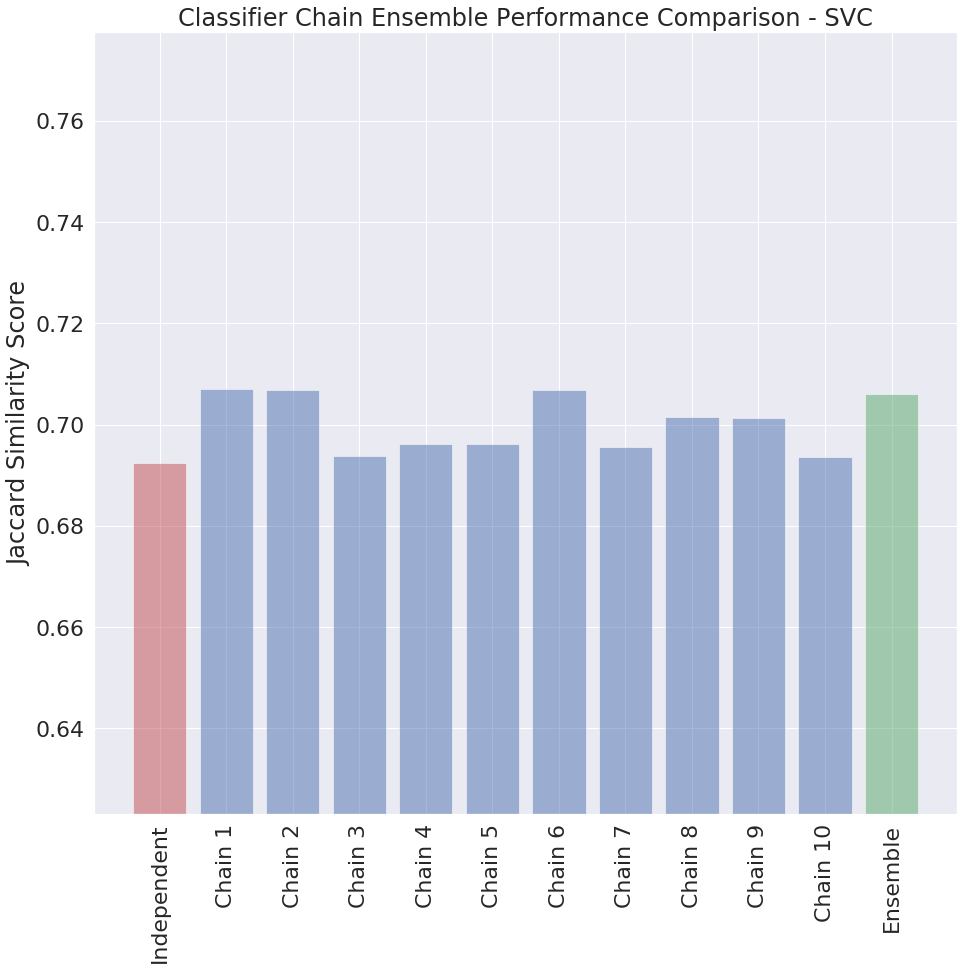

In [46]:
algoName = 'SVC'
# Fit an independent model for each class using the OneVsRestClassifier wrapper.
algo = SVC(kernel='linear')
Y_pred_ovr = OneVsRestClassifierWrapper(algo, X_train, Y_train, X_test)
# Jaccard similarity of actual v/s prediction across all labels
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average='samples')

# Fit an ensemble of classifier chains. Each chain contain one classifier per label. 
# Second classifier on, predictions of prior classifiers is included in training data to exploit label correlations.
# Since the label correlations & optimal classifier ordering are unknown apriori, the sequence of classifiers in each chain 
# is randomly ordered.
chains = [ClassifierChain(algo, order='random', random_state=i)
          for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

# predictions from chains
Y_pred_chainsSVC, Y_pred_ensembleSVC, model_scoresSVC, chain_jaccard_scoresSVC = predChainsEnsemble(ovr_jaccard_score, chains, X_test, Y_test)

# plot results 
plotScores(model_scoresSVC, chain_jaccard_scoresSVC, algoName)

In [47]:
#check a sample of prediction v/s actual
predictionCheck = predictCheck(Y_pred_ovr_RF, Y_test, test_meta, 'SVCOneVRest')
predictionCheck.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,toxicSVCOneVRest,severe_toxicSVCOneVRest,obsceneSVCOneVRest,threatSVCOneVRest,insultSVCOneVRest,identity_hateSVCOneVRest,noneSVCOneVRest
0,29bb05ac7ee4b466,1,1,1,0,1,0,0,1,0,1,0,0,0,0
1,319d648bdca28326,1,0,1,1,1,0,0,1,0,0,0,0,0,0
2,deea4cd724020ebc,1,0,1,0,1,0,0,1,0,0,0,0,0,0
3,81e2fd31d6972daa,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,326f2b7604034d4d,1,0,1,0,1,0,0,1,0,0,0,0,0,0


In [48]:
#check a sample of prediction v/s actual
predictionCheck = predictCheck(Y_pred_ensemble, Y_test, test_meta, 'SVCEnsemble')
predictionCheck.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,toxicSVCEnsemble,severe_toxicSVCEnsemble,obsceneSVCEnsemble,threatSVCEnsemble,insultSVCEnsemble,identity_hateSVCEnsemble,noneSVCEnsemble
0,29bb05ac7ee4b466,1,1,1,0,1,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,319d648bdca28326,1,0,1,1,1,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,deea4cd724020ebc,1,0,1,0,1,0,0,1.0,0.0,0.5,0.0,0.5,0.0,0.0
3,81e2fd31d6972daa,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,326f2b7604034d4d,1,0,1,0,1,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


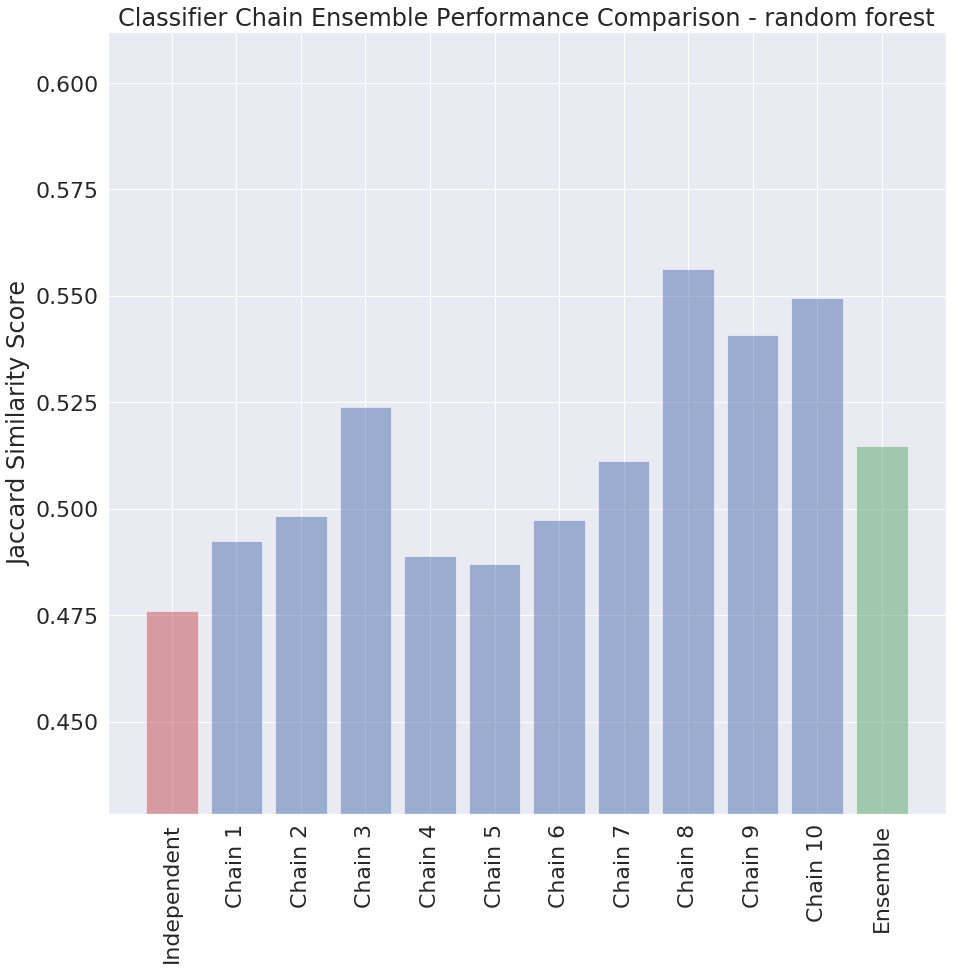

In [30]:
algoName = 'random forest'
# Fit an independent model for each class using the OneVsRestClassifier wrapper.
algo = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
Y_pred_ovr_RF = OneVsRestClassifierWrapper(algo, X_train, Y_train, X_test)
# Jaccard similarity of actual v/s prediction across all labels
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr_RF, average='samples')

# Fit an ensemble of classifier chains. Each chain contain one classifier per label. 
# Second classifier on, predictions of prior classifiers is included in training data to exploit label correlations.
# Since the label correlations & optimal classifier ordering are unknown apriori, the sequence of classifiers in each chain 
# is randomly ordered.
chains = [ClassifierChain(algo, order='random', random_state=i)
          for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

# predictions from chains
Y_pred_chains_RF, Y_pred_ensemble_RF, model_scores_RF, chain_jaccard_scores_RF = predChainsEnsemble(ovr_jaccard_score, chains, X_test, Y_test)

# plot results 
plotScores(model_scores_RF, chain_jaccard_scores_RF, algoName)

In [44]:
#check a sample of prediction v/s actual
predictionCheck = predictCheck(Y_pred_ovr_RF, Y_test, test_meta, 'RFOneVRest')
predictionCheck.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,toxicRFOneVRest,severe_toxicRFOneVRest,obsceneRFOneVRest,threatRFOneVRest,insultRFOneVRest,identity_hateRFOneVRest,noneRFOneVRest
0,29bb05ac7ee4b466,1,1,1,0,1,0,0,1,0,1,0,0,0,0
1,319d648bdca28326,1,0,1,1,1,0,0,1,0,0,0,0,0,0
2,deea4cd724020ebc,1,0,1,0,1,0,0,1,0,0,0,0,0,0
3,81e2fd31d6972daa,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,326f2b7604034d4d,1,0,1,0,1,0,0,1,0,0,0,0,0,0


In [45]:
#check a sample of prediction v/s actual
predictionCheck = predictCheck(Y_pred_ensemble, Y_test, test_meta, 'RFEnsemble')
predictionCheck.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,toxicRFEnsemble,severe_toxicRFEnsemble,obsceneRFEnsemble,threatRFEnsemble,insultRFEnsemble,identity_hateRFEnsemble,noneRFEnsemble
0,29bb05ac7ee4b466,1,1,1,0,1,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1,319d648bdca28326,1,0,1,1,1,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,deea4cd724020ebc,1,0,1,0,1,0,0,1.0,0.0,0.5,0.0,0.5,0.0,0.0
3,81e2fd31d6972daa,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,326f2b7604034d4d,1,0,1,0,1,0,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [0]:
#Jaccard score parameters explanation from sklearn
#'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
# 'samples': Calculate metrics for each instance, and find their average (only meaningful for multilabel classification).

y_true  = np.array([[0, 1, 1],
                    [1, 1, 0]])
y_pred1 = np.array([[1, 1, 1],
                    [1, 0, 0]])
y_pred2 = np.array([[1, 1, 1],
                    [0, 1, 0]])
y_pred3 = np.array([[1, 1, 1],
                    [0, 0, 1]])

print(jaccard_score(y_true, y_pred1, average='macro'))
print(jaccard_score(y_true, y_pred2, average='macro'))
print(jaccard_score(y_true, y_pred3, average='macro'))#note how the position of the 1 (and hence label wise match), affects score

print(jaccard_score(y_true, y_pred1, average='samples'))
print(jaccard_score(y_true, y_pred2, average='samples'))
print(jaccard_score(y_true, y_pred3, average='samples'))

0.6666666666666666
0.6666666666666666
0.3333333333333333
0.5833333333333333
0.5833333333333333
0.3333333333333333


In [0]:
#this did not converge and is left in place for completeness

algoName = 'logistic regression'
# Fit an independent model for each class using the OneVsRestClassifier wrapper.
algo = LogisticRegression(solver='lbfgs')
Y_pred_ovr = OneVsRestClassifierWrapper(algo, X_train, Y_train, X_test)
# Jaccard similarity of actual v/s prediction across all labels
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average='samples')

# Fit an ensemble of classifier chains. Each chain contain one classifier per label. 
# Second classifier on, predictions of prior classifiers is included in training data to exploit label correlations.
# Since the label correlations & optimal classifier ordering are unknown apriori, the sequence of classifiers in each chain 
# is randomly ordered.
chains = [ClassifierChain(algo, order='random', random_state=i)
          for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

# predictions from chains
Y_pred_chains, Y_pred_ensemble, model_scores, chain_jaccard_scores = predChainsEnsemble(ovr_jaccard_score, chains, X_test, Y_test)

# plot results 
plotScores(model_scores, chain_jaccard_scores, algoName)